In [6]:
import torch
import numpy as np
import sys
import os
from pathlib import Path
import pyvista as pv

if Path.cwd().as_posix().endswith('/mean_flows_01'):
    os.chdir('../..')
from src.eval import GeometryEstimator

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
pv.set_jupyter_backend("trame")

In [2]:
def get_data(data_name, noise_level=0.0, noise_ratio=0.0):
    data_path = os.path.join('example_data', data_name)
    data = {}
    for file in os.listdir(data_path):
        if file.endswith('.npy'):
            data[file[:-4]] = torch.from_numpy(np.load(os.path.join(data_path, file))).to(device)
    if noise_level > 0.0 and noise_ratio > 0.0:
        xyz = data['xyz']
        noise_inds = torch.randperm(xyz.shape[0])[:int(noise_ratio*xyz.shape[0])]
        noise = torch.randn_like(xyz[noise_inds]) * noise_level
        xyz[noise_inds] += noise
        data['xyz'] = xyz
    return data

In [3]:
file = 'spot'

data_clean = get_data(file)
estimator_clean = GeometryEstimator(data_clean['xyz'], 
                              orientation=data_clean['normals'], 
                              device='cuda')

In [ ]:
flow_data = estimator_clean.mean_flow(num_steps=250, 
                                      save_data_per_step=25,
                                      delta_t=0.0002,
                                      subsample_radius=0.005,
                                      smooth_radius=0.06,
                                      smooth_x=False)

100%|██████████| 250/250 [4:48:10<00:00, 69.16s/it]  


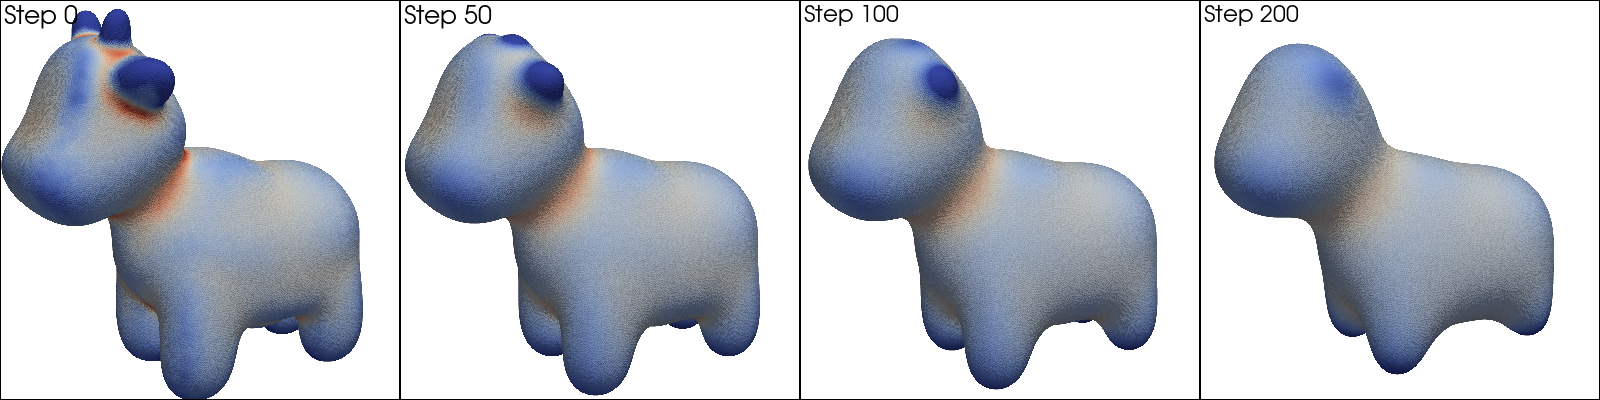

In [26]:
camera_pos = [(-5.515810949058437, 1.6733713203173721, -2.9265943826878433),
              (6.279349327087402e-05, 0.2162138819694519, 0.029896080493927002),
              (0.19613395058580294, 0.9739175157878064, 0.11408832485979425)]
steps = [0, 2, 4, 8]
plotter = pv.Plotter(shape=(1, len(steps)), window_size=(1600, 400))
window = 0
for i, step in enumerate(flow_data):
    if i not in steps:
        continue
    poly_data = pv.PolyData(step['x'].cpu().numpy())
    poly_data['mean_curvature'] = step['mean_curvature'].cpu().numpy()
    
    plotter.subplot(0, window)
    plotter.add_points(poly_data, 
                       style='points', 
                       point_size=8, 
                       render_points_as_spheres=True,
                       cmap='coolwarm',
                       scalars='mean_curvature', 
                       clim=[-5, 5],
                       copy_mesh=True)
    plotter.add_text(f'Step {25*i}', font_size=10)
    plotter.camera_position = camera_pos
    plotter.camera.zoom(1)
    plotter.remove_scalar_bar()
    window += 1
plotter.show()